## [문제1] 로지스틱 회귀

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [2]:
# 유방암 데이터 추출
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names) # data
y = pd.Series(data.target) # target

# 데이터셋 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
# 로지스틱 회귀 모델 학습
log_reg_model = LogisticRegression(max_iter=10000) # max_iter = 10000으로 두기
log_reg_model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [4]:
# 결정 트리 모델 학습
tree_model = DecisionTreeClassifier(random_state = 42) # random_state=42로 두기
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [5]:
# 로지스틱 회귀 모델 평가
log_reg_score = log_reg_model.score(X_test, y_test)
print("로지스틱 회귀 정확도:", log_reg_score)

# 결정 트리 모델 평가
tree_score = tree_model.score(X_test, y_test)
print("결정 트리 정확도:", tree_score)

로지스틱 회귀 정확도: 0.956140350877193
결정 트리 정확도: 0.9473684210526315


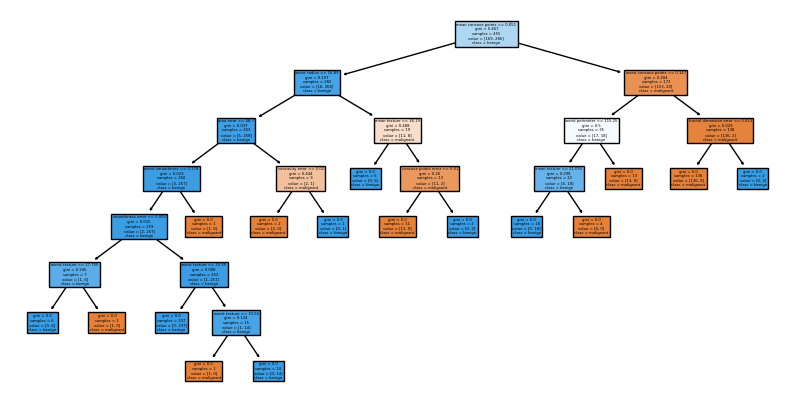

In [6]:
# 그래프 크기 조정
plt.figure(figsize=(10, 5))

# 결정 트리 시각화
plot_tree(tree_model, feature_names=data.feature_names, class_names=data.target_names, filled=True)
plt.show()

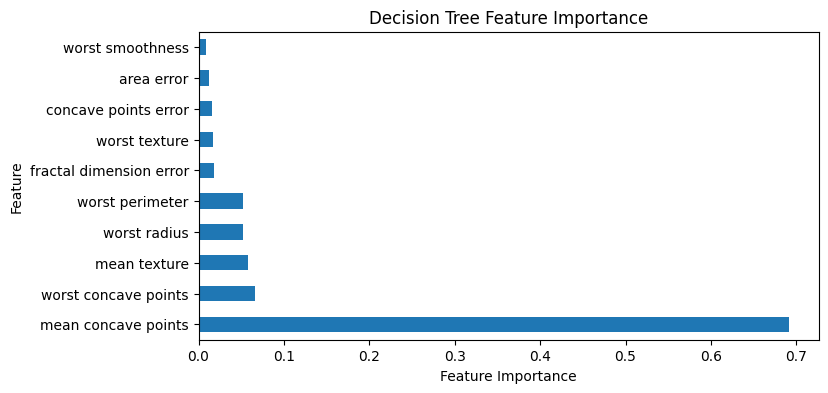

In [7]:
# 그래프 크기 조정
plt.figure(figsize=(8, 4))

# 특성 중요도 시각화
feat_importances = pd.Series(tree_model.feature_importances_, index=data.feature_names)
feat_importances.nlargest(10).plot(kind='barh')

plt.title('Decision Tree Feature Importance') # 그래프 제목: 결정 트리 특성 중요도
plt.xlabel('Feature Importance') # x축: 특성 중요도
plt.ylabel('Feature') # y축: 특성
plt.show()

## [문제2] 교차 검증

In [8]:
from sklearn.datasets import load_iris

In [9]:
#붓꽃 데이터
iris = load_iris()
data = iris.data
target = iris.target

In [10]:
#데이터 분할
train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42)

In [11]:
sub_input, val_input, sub_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

In [12]:
print(sub_input.shape, val_input.shape)

(96, 4) (24, 4)


In [13]:
#의사 결정 트리 모델 생성 및 학습
dt = DecisionTreeClassifier(random_state=42)
dt.fit(sub_input, sub_target)

DecisionTreeClassifier(random_state=42)

In [14]:
#훈련 및 검증 성능 출력
print(dt.score(sub_input, sub_target))
print(dt.score(val_input, val_target))

1.0
0.9166666666666666


In [15]:
#교차 검증 수행
scores = cross_validate(dt, test_input, test_target)
print(scores)

{'fit_time': array([0.00209355, 0.00140715, 0.00133848, 0.00124168, 0.00148416]), 'score_time': array([0.00099301, 0.00085807, 0.00085044, 0.00103378, 0.0007906 ]), 'test_score': array([0.83333333, 0.83333333, 0.83333333, 1.        , 1.        ])}


In [16]:
print(np.mean(scores['test_score']))

0.9


In [17]:
#Stratified K-Fold 교차 검증 수행
scores = cross_validate(dt, test_input, test_target, cv=StratifiedKFold())
print(np.mean(scores['test_score']))

0.9


In [18]:
#Stratified K-Fold 교차 검증 수행 (n_splits=10)
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_validate(dt, train_input, train_target, cv=splitter)
print(np.mean(scores['test_score']))

0.9333333333333333


------

-----------

## 타이타닉 데이터 세트 준비

In [19]:
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform,  randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

# 타이타닉 데이터셋의 URL
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"

# 데이터셋 불러오기
titanic_data = pd.read_csv(url)

##########타이타닉 데이터셋에 대한 설명###########
# Survived (타겟 변수): 승객의 생존 여부를 나타냅니다. 0은 사망, 1은 생존을 의미합니다.
# Pclass: 승객의 티켓 클래스로, 사회경제적 지위를 대략적으로 나타냅니다. 1은 1등석, 2는 2등석, 3은 3등석을 의미합니다.
# Name: 승객의 이름입니다.
# Sex: 승객의 성별입니다. 남성은 'male', 여성은 'female'로 표시됩니다.
# Age: 승객의 나이입니다. 일부 승객의 나이는 추정치일 수 있습니다.
# SibSp: 타이타닉호에 함께 탑승한 형제, 자매 또는 배우자의 수입니다.
# Parch: 타이타닉호에 함께 탑승한 부모 또는 자녀의 수입니다.
# Ticket: 티켓 번호입니다.
# Fare: 탑승 요금입니다.
# Cabin: 객실 번호입니다. 많은 결측치를 포함하고 있습니다.
# Embarked: 승객이 타이타닉호에 탑승한 항구를 나타냅니다. C는 셰르부르(Cherbourg), Q는 퀸스타운(Queenstown), S는 사우샘프턴(Southampton)을 의미합니다.
###########################################

# 과제 수행에 용이하도록 원본 데이터 셋을 간단하게 변경하였습니다.

# 불필요한 컬럼 제거
titanic_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked'], axis=1, inplace=True)

# Sex 컬럼 변환: 남자는 1, 여자는 2
titanic_data['Sex'] = titanic_data['Sex'].map({'male': 1, 'female': 2})

# 결측치가 아닌 Age 값들의 평균 계산
age_mean = titanic_data['Age'].mean()

# Age 컬럼의 결측치를 나이의 평균으로 채우기
titanic_data['Age'].fillna(titanic_data['Age'].mean(), inplace=True)

/usr/local/lib/python3.10/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [20]:
# 변환된 데이터셋 확인
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,1,22.0,1,0,7.2500
1,1,1,2,38.0,1,0,71.2833
2,1,3,2,26.0,0,0,7.9250
3,1,1,2,35.0,1,0,53.1000
4,0,3,1,35.0,0,0,8.0500


In [21]:
# 데이터 세트에 대한 통계량 출력
titanic_data.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,1.352413,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,0.477990,13.002015,1.102743,0.806057,49.693429
min,0.000000,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,1.000000,22.000000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,1.000000,29.699118,0.000000,0.000000,14.454200
75%,1.000000,3.000000,2.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,2.000000,80.000000,8.000000,6.000000,512.329200


In [22]:
# target attribute 분리
data = titanic_data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']].to_numpy()
target = titanic_data['Survived'].to_numpy()

# 훈련데이터, 테스트데이터 분할
train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42
)

# 훈련데이터에서 검증데이터셋 분할
sub_input, val_input, sub_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42
)

# 데이터 세트 크기 확인
print(" 훈련:", sub_input.shape, "\n", "검증:", val_input.shape, "\n", "테스트:", test_input.shape)

 훈련: (569, 6) 
 검증: (143, 6) 
 테스트: (179, 6)


## 모델 확인하기

In [23]:
# 검증 데이터로 과적합 여부 확인
dt = DecisionTreeClassifier(random_state=42)
dt.fit(sub_input, sub_target)
print("훈련 점수:", dt.score(sub_input, sub_target))
print("검증 점수:", dt.score(val_input, val_target))

훈련 점수: 0.9859402460456942
검증 점수: 0.7902097902097902


In [24]:
# 교차 검증(k-fold cross validatioin) 확인
splitter = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) # 3 폴드 교차 검증
scores = cross_validate(dt, train_input, train_target, cv = splitter) # !훈련 세트 전체를 전달해야 한다
print(scores)
print("교차 검증의 최종 점수: ", np.mean(scores['test_score']))

{'fit_time': array([0.00370169, 0.0019536 , 0.00172544]), 'score_time': array([0.00126314, 0.00079346, 0.00065684]), 'test_score': array([0.78151261, 0.79746835, 0.75949367])}
교차 검증의 최종 점수:  0.7794915434528242


---
# 하이퍼파라메터 튜닝

## [문제 3] "your code" (1) ~(4)를 채워봅시다.

### your code(1): 0.0001부터 0.001까지 0.0001만큼 더한 값들의 배열을 만드는 함수
### your code(2): 실수값이 아닌 정수값에 대해서 3부터 15까지 1씩 더한 값들의 배열을 만든는 함수
### your code(3): 노드를 나누기 위한 최소 샘플 수를 지정하는 하이퍼 파라메터를 2에서 50까지 10씩 더한 값들의 배열을 만드는 함수로 구간을 설정
### your code(4): 최적의 매개변수 조합 확인하기

In [29]:
# 그리드 서치(복잡한 매개변수 조합 탐색하기)
params = {'min_impurity_decrease' : np.arange(0.0001, 0.001, 0.0001),# arange(): 0.0001부터 0.001까지 0.0001만큼 더한 값들의 배열
          'max_depth' : range(3, 15),                            # range() : arange()와 비슷하지만 정수에 대해서만 가능
          'min_samples_split' : range(2, 50, 10)
          }

gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(3, 15),
                         'min_impurity_decrease': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'min_samples_split': range(2, 50, 10)})

In [30]:
# 최적의 매개변수 조합 확인하기
print("최적의 매개변수 조합:", gs.best_params_)

# 최적의 교차 검증 점수 확인하기
print("최적의 교차 검증 점수:", np.max(gs.cv_results_['mean_test_score']))

최적의 매개변수 조합: {'max_depth': 3, 'min_impurity_decrease': 0.0001, 'min_samples_split': 2}
최적의 교차 검증 점수: 0.8202107751403526


---
## [문제 4] "your code" (1) ~(4)를 채워봅시다.
### your code(1): 랜덤서치에서 매개변수를 샘플링 할 수 있는 확률 분포 객체 중 정수값과 실수값에 해당하는 클래스를 각각 알맞게 써봅시다.
### your code(2): 샘플링 횟수를 100으로 설정(사이킷런의 랜덤 서치 클래스인 RandomizedSearchCV에서 샘플링 횟수를 지정해주는 매개변수를 이용)
### your code(3): 최적의 교차 검증 점수 확인하기
### your code(4): 최적의 모델이 저장되어있는 속성을 불러오기

In [32]:
# 랜덤 서치(복잡한 매개변수 조합 탐색하기)
params = {'min_impurity_decrease' : np.arange(0.0001, 0.001),
          'max_depth' : range(10, 55),
          'min_samples_split' : range(2, 20),
          'min_samples_leaf' : np.arange(1, 30)
          }

gs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params, n_iter = 100, n_jobs=-1, random_state=42)
gs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': range(10, 55),
                                        'min_impurity_decrease': array([0.0001]),
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                                        'min_samples_split': range(2, 20)},
                   random_state=42)

In [33]:
# 최적의 매개변수 조합
print("최적의 매개변수 조합:", gs.best_params_)

# 최적의 교차 검증 점수
print("최적의 교차 검증 점수:", gs.score(val_input, val_target))

# 최종 모델의 테스트 세트 성능 확인하기
dt = gs.best_estimator_ # 최적의 모델이 저장되어 있는 속성
print("최종 테스트 성능", dt.score(test_input, test_target))

최적의 매개변수 조합: {'min_samples_split': 18, 'min_samples_leaf': 14, 'min_impurity_decrease': 0.0001, 'max_depth': 18}
최적의 교차 검증 점수: 0.8601398601398601
최종 테스트 성능 0.7932960893854749


---
# 트리의 앙상블

## [문제 5] 코드 작성
### 랜덤포레스트에서 OOB(Out of bag)점수를 확인할 수 있도록 코드를 작성해봅시다.(2줄)

In [34]:
# 랜덤포레스트 모델
rf = RandomForestClassifier(n_jobs=-1, random_state=42)

scores = cross_validate(rf, train_input, train_target, return_train_score=True, n_jobs=-1)
print("훈련 점수:", np.mean(scores['train_score']), "검증 점수", np.mean(scores['test_score']))

# 랜덤 포레스트 모델을 훈련 세트에 훈련한 후 특성 중요도를 출력하기 [Survived	Pclass	Sex	Age	SibSp	Parch	Fare]
rf.fit(train_input, train_target)
print("특성 중요도:", rf.feature_importances_)

# OOB점수 출력하기
rf = RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=42)
rf.fit(train_input, train_target)
print("OOB점수: ", rf.oob_score_)

훈련 점수: 0.9834964388123207 검증 점수 0.8019107652910471
특성 중요도: [0.07958375 0.27249939 0.26124602 0.04939013 0.03793941 0.29934129]
OOB점수:  0.8033707865168539


---
## [문제 6] 빈칸 채우기
### your code에 공통으로 들어갈 변수를 입력하기

In [36]:
# 히스토그램 기반 그레디언트 부스팅 활용
hgb = HistGradientBoostingClassifier(random_state=42)
scores = cross_validate(hgb, train_input, train_target, return_train_score=True)
print("훈련 점수:", np.mean(scores['train_score']), "검증 점수:", np.mean(scores['test_score']))

# 히스토그램 기반 그레디언트 부스팅의 특성 중요도 확인
hgb.fit(train_input, train_target)
print("특성 중요도: ", rf.feature_importances_)

# 히스토그램 기반 그래디언트의 테스트 세트에서의 최종적인 성능 확인
print("최종 테스트 성능", hgb.score(test_input, test_target))

훈련 점수: 0.9368014059753955 검증 점수: 0.8244558258642766
특성 중요도:  [0.07958375 0.27249939 0.26124602 0.04939013 0.03793941 0.29934129]
최종 테스트 성능 0.8156424581005587


# 생각해보기

### 1. 그리드 서치를 통한 의사결정나무의 하이퍼파라메터 튜닝에서 min_impurity_decrease, max_depth, min_samples_split, min_samples_leaf, splitter 말고 어떠한 매개변수가 있을까?

---

### 답 : criterion, splitter, max_features, max_leaf_nodes

### 2. 엑스트라 트리와 랜덤포레스트의 차이점으로 인해 갖게 되는 장단점은 무엇이 있을까?

---

### 답: 엑스트라 트리는 랜덤 포레스트보다 더 많은 decision tree를 훈련해야 하지만, 랜덤하게 노드를 분할하기 때문에 계산 속도가 더 빠르다!



### 3. 그레디언트 부스팅 기법은 학습률과 트리개수를 증가시켜도 과대적합을 거의 억제할 수 있는 이유는 무엇일까?

---

### 답: 깊이가 얕은 decision tree를 사용하여 이전 tree의 오차를 보완하는 방식으로 앙상블 하기 때문이다. 그렇기에 과적합에 강하다.